# Матрично-векторное дифференцирование. Практика (20 баллов)

In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import itertools
import cv2

## Основная часть (всего 10 баллов)

__Задача 1. (1 балл)__ Пусть $x \in \mathbb{R}^d$ вычисляется следующим образом: $x = A^{-1}b$, где $A \in \mathbb{S}_{++}^d$, $b \in \mathbb{R}^d$, а лосс равен $\mathcal{L} (x)$. Найдите градиенты $\nabla_A \mathcal{L}$, $\nabla_b \mathcal{L}$. Градиент по $x$ считать известным и равным $\nabla_x \mathcal{L}$.

__Задача 2.__ Перед вами стоит задача приближения матрицы $X \in \mathbb{R}^{n \times d}$ неизвестными матрицами $U \in \mathbb{R}^{r \times n}$, $V \in \mathbb{R}^{r \times d}$ заданной размерности $r$. Такое приближение часто используется при поиске малоранговых приближений для передачи сжатой информации с минимальными потерями.

В качестве такого приближения предлагается использовать линейное представление $\hat{X} = U^\top V$. Для оценки качества приближения будем использовать функцию $MSE$:

$$MSE(X, \hat{X}) = \frac{1}{2} \left\| X - \hat{X} \right\|^2_F = \frac{1}{2} \left\| X - U^\top V \right\|^2_F.$$

В качестве матрицы $X$ предлагается рассмотреть [изображение](https://github.com/BRAIn-Lab-teaching/OPTIMIZATION-METHODS-COURSE/blob/ПМИ_осень_2025/Datasets/bridge.pgm) моста из датасета, созданного для бенчмаркинга различных матричных разложений __ImageCompressionBenchmark__.

In [2]:
url = "https://raw.githubusercontent.com/BRAIn-Lab-teaching/OPTIMIZATION-METHODS-COURSE/%D0%9F%D0%9C%D0%98_%D0%BE%D1%81%D0%B5%D0%BD%D1%8C_2025/Datasets/bridge.pgm"
!wget -O bridge.pgm "$url"

--2025-10-09 20:09:23--  https://raw.githubusercontent.com/BRAIn-Lab-teaching/OPTIMIZATION-METHODS-COURSE/%D0%9F%D0%9C%D0%98_%D0%BE%D1%81%D0%B5%D0%BD%D1%8C_2025/Datasets/bridge.pgm
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22261421 (21M) [application/octet-stream]
Saving to: ‘bridge.pgm’

bridge.pgm          100%[===================>]  21.23M  --.-KB/s    in 0.1s    

2025-10-09 20:09:23 (152 MB/s) - ‘bridge.pgm’ saved [22261421/22261421]



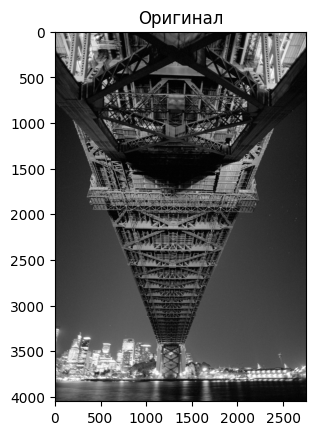

In [3]:
X = cv2.imread('bridge.pgm', -1)
n, d = X.shape
plt.imshow(X, cmap='gray')
plt.title('Оригинал')
plt.show()

__a) (1 балл)__  Для поиска линейного разложения, первым будет предложен градиентный спуск. Для этого вычислите аналитически $\nabla_U MSE$, $\nabla_V MSE$.

Реализуйте функцию подсчета градиента, возвращающую значения для вычисленных аналитически градиентов.

In [4]:
def grad(U, V, X):
    """
    Вычисляет градиенты для матриц U и V относительно функции потерь.

    Параметры:
        U (np.ndarray): Матрица размера r x n.
        V (np.ndarray): Матрица размера r x d.
        X (np.ndarray): Матрица размера n x d.

    Возвращает:
        grad_U (np.ndarray): Градиент по матрице U, размерность r x n.
        grad_V (np.ndarray): Градиент по матрице V, размерность r x d.
    """

    E = U.T @ V - X
    grad_U = V @ E.T
    grad_V = U @ E

    return grad_U, grad_V

__б) (0.5 балла)__ В качестве функции критерия используем $MSE\left(X, \hat{X}^k\right)$. Реализуйте функцию для подсчета критерия.

In [5]:
def criterion(X, X_hat):
    """
    Вычисляет значение критерия (функции потерь) между целевой матрицей X и приближением X_hat.

    Параметры:
        X (np.ndarray): Целевая матрица, размерность (n, d).
        X_hat (np.ndarray): Приближение матрицы X, размерность (n, d).

    Возвращает:
        MSE (float): Значение критерия.
    """

    diff = X - X_hat
    MSE = np.linalg.norm(diff, ord='fro')

    return MSE

Для вашего удобства, мы реализовали функцию генерации начальных значений для матриц $U$ и $V$. Данную функцию изменять НЕ НУЖНО. Используя данную функцию создайте начальные значения для матриц $U$ и $V$ с $r = 10$.

In [6]:
def generate_starting_points(r, n, d):
    """
    Генерирует начальные значения матриц U и V для задачи матричной факторизации.

    Параметры:
        r (int): Размерность латентного пространства.
        n (int): Количество строк в матрице X.
        d (int): Количество столбцов в матрице X.

    Возвращает:
        U (np.ndarray): Начальная матрица U, размерность (r, n).
        V (np.ndarray): Начальная матрица V, размерность (r, d).
    """
    np.random.seed(1)  # Фиксируем seed для воспроизводимости

    # Генерация случайных матриц U и V с малыми значениями
    U = 0.01 * np.random.randn(r, n)
    V = 0.01 * np.random.randn(r, d)

    return U, V

In [8]:
U, V = generate_starting_points(10, n, d)

__в) (2 балла)__  Положим ранг $r = 10$. Реализуйте метод градиентного спуска. Для удобства восприятия графиков ошибок, используйте отнормированные значения критерия, то есть

$$\left(MSE \left(X, \hat{X}^k \right) ~/~ MSE \left(X, \hat{X}^0 \right) \right),$$

где $ \hat{X}^k$ и $ \hat{X}^0$ — значения полученных аппроксимаций на $k$-ой и нулевой итерациях, соответственно.

**Псевдокод алгоритма**

---

_Инициализация:_

- Начальные матрицы $ U^0 $ и $ V^0 $
- Величина шага $\{ \gamma_k \}_{k = 0} > 0$
- Максимальное число итераций $K$

---

$k$_-ая итерация_:

1. Сделать шаг градиентного спуска:

$$\begin{align*}
&U^{k + 1} = U^k - \gamma_k \nabla_U MSE \left(X, \hat{X}^k \right) \\
&V^{k + 1} = V^k - \gamma_k \nabla_V MSE \left(X, \hat{X}^k \right)
\end{align*}$$

2. Пересчитать $\hat{X}^{k + 1}$:

$$\hat{X}^{k + 1} = \left(U^{k + 1}\right)^\top V^{k + 1}$$

---

_Условие остановки:_
- $\left(MSE \left(X, \hat{X}^k \right) ~/~ MSE \left(X, \hat{X}^0 \right) \right) < \varepsilon$

---

_Выход:_
- Полученное значение $\hat{X}^K$

In [ ]:
def matrix_gd(grad, criterion, U_0, V_0, X, eps=1e-3, max_iter=1000, **params):
    """
    Реализация градиентного спуска для задачи матричной факторизации.

    Параметры:
        grad (Callable): Функция, вычисляющая градиент целевой функции. Принимает на вход матрицы U, V, X
        criterion (Callable): Функция, вычисляющая критерий сходимости. Принимает на вход матрицы X и X^k
        U_0 (np.ndarray): Начальная матрица U, размерность (r, n)
        V_0 (np.ndarray): Начальная матрица V, размерность (r, d)
        X (np.ndarray): Целевая матрица, размерность (n, d)
        eps (float): Точность сходимости (обычно 1e-3)
        max_iter (int): Максимальное количество итераций
        **params: Именованные гиперпараметры метода:
            params['gamma'](k) — функция, возвращающая шаг на итерации k

    Возвращает:
        X^k (np.ndarray): Приближение матрицы X, размерность (n, d).
        errors (list): Список значений критерия сходимости на каждой итерации.
    """
    errors = []

    X_0 = U_0.T @ V_0
    X_k = np.copy(X_0)
    U = np.copy(U_0)
    V = np.copy(V_0)

    err_x_0 = criterion(X, X_k)
    errors.append(criterion(X, X_k) / err_x_0)

    for k in tqdm(range(max_iter)):

        # YOUR CODE HERE

        errors.append(criterion(X, X_k) / err_x_0)

        if errors[-1] < eps:
            break

    return X_k, errors

Запустите метод `matrix_gd` для сгенерированных стартовых матриц $U^0, V^0$. В качестве шага подберите значение из предложенных: $\gamma = \{10^{-6}, 10^{-7}, 10^{-8}\}$.

In [ ]:
# Ваше решение (Code)

Постройте график значений критерия от номера итерации.

In [ ]:
# Ваше решение (Code)

Выведите в виде картинки полученный результат $\hat{X}^k$.

In [ ]:
def draw_images(images):
    """
    Функция визуализации полученных приближений X_hat.

    Параметры:
        images (list of dict): Массив словарей вида {'image': restored_image, 'title': title}.
    """
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(n * 4, 4))
    if n == 1:
        axes = [axes]

    for ax, img_dict in zip(axes, images):
        ax.imshow(img_dict['image'], cmap='gray')
        ax.set_title(img_dict['title'])

    plt.tight_layout()
    plt.show()

In [ ]:
# Ваше решение (Code)

__г) (1.5 балла)__ Следующий этап — сравнить качество приближений в зависимости от ранга $r$. Рассмотрите следующие значения $r = \{1, 10, 100\}$. Шаг оставьте тот, для которого наблюдалась сходимость в предыдущем пункте.

In [ ]:
# Ваше решение (Code)

Постройте сравнительный график зависимости значения нормированного критерия от номера итерации $k$.

In [ ]:
# Ваше решение (Code)

Выведите в виде картинки полученный результат.

In [ ]:
# Ваше решение (Code)

__Задача 3.__ Теперь, когда вы реализовали метод градиентного спуска для подсчета аппроксимации, перейдем к рассмотрению безградиентного метода AlternatingLeastSquares (`ALS`) также довольно популярного при работе с восстановлением изображений.

**Псевдокод алгоритма**

---

_Инициализация:_

- Начальные матрицы $U^0$ и $V^0$
- Параметр регуляризации $\lambda > 0$  
- Максимальное число итераций $K$

---

$k$_-ая итерация:_

1. Обновление матрицы $U^{k + 1}$:
   
   $$
   U^{k + 1} = \left(V^k \left(V^k\right)^\top + \lambda I_r \right)^{-1} V^k \left(X\right)^\top
   $$

2. Обновление матрицы $V^{k + 1}$:

   $$
   V^{k + 1} = \left(U^{k + 1} \left(U^{k + 1}\right)^\top + \lambda I_r \right)^{-1} U^{k + 1} X
   $$

---

_Условие остановки:_
- $\left(MSE \left(X, \hat{X}^k \right) ~/~ MSE \left(X, \hat{X}_0 \right) \right) < \varepsilon$

---

_Выход:_
- Полученное значение $\hat{X}^K$

__а) (2 балла)__ Реализуйте метод `ALS`.

In [ ]:
def ALS(criterion, U_0, V_0, X, eps, max_iter, **params):
    """
    Реализация метода ALS для задачи матричной факторизации.

    Параметры:
        criterion (Callable): Функция, вычисляющая критерий сходимости. Принимает на вход матрицы X и X^k.
        U_0 (np.ndarray): Начальная матрица U, размерность (r, n).
        V_0 (np.ndarray): Начальная матрица V, размерность (r, d).
        X (np.ndarray): Целевая матрица, размерность (n, d).
        eps (float): Точность сходимости (обычно 1e-3).
        max_iter (int): Максимальное количество итераций.
        **params: Именованные гиперпараметры метода:
            params['lmbda'] (float): Константа для регуляризации задачи поиска обратной матрицы.

    Возвращает:
        X^k (np.ndarray): Приближение матрицы X, размерность (n, d).
        errors (list): Список значений критерия сходимости на каждой итерации.
    """
    errors = []

    X_0 = U_0.T @ V_0
    X_k = np.copy(X_0)
    U = np.copy(U_0)
    V = np.copy(V_0)

    err_x_0 = criterion(X, X_k)
    errors.append(criterion(X, X_k) / err_x_0)

    for k in tqdm(range(max_iter)):

        # YOUR CODE HERE

        errors.append(criterion(X, X_k) / err_x_0)

        if errors[-1] < eps:
            break

    return X_k, errors

Запустите метод с максимальным числом итераций равным 100, рангом $r = 10$ и значениями $\lambda = \{1, 10, 100\}$.

In [ ]:
# Ваше решение (Code)

Постройте сравнительный график значения нормированного критерия от номера итерации $k$.

In [ ]:
# Ваше решение (Code)

Восстановите изображения.

In [ ]:
# Ваше решение (Code)

__б) (1.5 балл)__ Как и в предыдущем задании, теперь необходимо сравнить качество приближений в зависимости от ранга $r$. Число итераций поставьте равным 10. Рассмотрите следующие значения $r = \{1, 10, 100\}$. Параметр $\lambda$ выберите на ваше усмотрение.

In [ ]:
# Ваше решение (Code)

Постройте сравнительный график зависимости значения нормированного критерия от номера итерации $k$.

In [ ]:
# Ваше решение (Code)

Восстановите изображения.

In [ ]:
# Ваше решение (Code)

__в) (0.5 балла)__ Теперь, когда вы познакомились с двумя методами по поиску линейного разложения матрицы в случае фиксированного ранга, сделайте вывод о применимости каждого из них? Есть ли какие-то преимущества у метода `ALS` в сравнении с `matrix_gd`? Когда можно применять каждый из них?

In [ ]:
# Ваше решение (Markdown)

## Дополнительная часть (всего 10 баллов)

__Задача 4.__ Как было рассказано на лекциях и семинарах, для поиска ошибки в машинном обучении строится граф вычислений на основе метода _backpropagation_. В данной части вам будет представлена возможность самостоятельно реализовать различные модули, используемые в нейронных сетях. Для начала представим универсальный класс `Module`, который определит фундаментальные методы для обучения (в нём НЕ НУЖНО ничего менять).

Первым является __forward pass__ — модуль получает входные данные, как-то их обрабатывает, а после выдает полученный результат, то есть

$$\text{output = module.forward(input)}.$$

Вторым же, как несложно догадаться, является __backward backpropagation__ — по цепному правилу прокидывается градиент от последнего слоя к первому, то есть

$$\text{gradInput = module.backward(input, gradOutput)}.$$

In [6]:
import torch

class Module(object):
    def __init__ (self):
        self.output = None
        self.gradInput = None
        self.training = True

    def forward(self, input):
        return self.updateOutput(input)

    def backward(self,input, gradOutput):
        self.updateGradInput(input, gradOutput)
        self.accGradParameters(input, gradOutput)
        return self.gradInput

    def updateOutput(self, input):
        pass

    def updateGradInput(self, input, gradOutput):
        pass

    def accGradParameters(self, input, gradOutput):
        pass

    def zeroGradParameters(self):
        pass

    def getParameters(self):
        return []

    def getGradParameters(self):
        return []

    def train(self):
        self.training = True

    def evaluate(self):
        self.training = False

    def __repr__(self):
        return "Module"

__а) (2 балла)__ Реализуйте класс [`Sequential`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Sequential.html), определяющий контейнер для последовательной обработки модулей.

In [24]:
class Sequential(Module):
    def __init__ (self):
        super(Sequential, self).__init__()
        self.modules = []

    def add(self, module):
        self.modules.append(module)

    def updateOutput(self, input):
        '''
            В данной функции нужно реализовать
            последовательную передачу данных в
            forward pass, используя в качестве
            входа в новом уровне выход со старого.
        '''

        self.output = input

        for module in self.modules:
            self.output = module.forward(self.output)

        return self.output

    def backward(self, input, gradOutput):
        '''
            Здесь нужно реализовать последовательную
            передачу градиента по цепному правилу.
            ВАЖНО: убедитесь в том, что при подсчете
            k-го градиента на вход подается output module[k-1],
            а не его input.
        '''

        current_grad = gradOutput
        for i in range(len(self.modules)-1, 0, -1):
            current_grad = self.modules[i].backward(self.modules[i - 1].output, current_grad)
        self.gradInput = self.modules[0].backward(input, current_grad)
        return self.gradInput


    def zeroGradParameters(self):
        for module in self.modules:
            module.zeroGradParameters()

    def getParameters(self):
        return [x.getParameters() for x in self.modules]

    def getGradParameters(self):
        return [x.getGradParameters() for x in self.modules]

    def __repr__(self):
        string = "".join([str(x) + '\n' for x in self.modules])
        return string

    def __getitem__(self,x):
        return self.modules.__getitem__(x)

    def train(self):
        self.training = True
        for module in self.modules:
            module.train()

    def evaluate(self):
        self.training = False
        for module in self.modules:
            module.evaluate()

__б) (2 балла)__ Реализуйте класс [`Linear`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html) (также известный как _dense layer_, _fully-connected layer_, _FC-layer_). Он работает с 2D входными данными размера (n_samples, n_feature). Так как обычно данные передаются в виде батча, то вход и выход могут быть записаны так:
- input:  `batch_size x n_feature_1`
- output: `batch_size x n_feature_2`

In [25]:
class Linear(Module):
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()

        stdv = 1./np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size = (n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size = n_out)

        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)

    def updateOutput(self, input):

        self.output = np.dot(input, self.W.T) + self.b

        return self.output

    def updateGradInput(self, input, gradOutput):

        self.gradInput = np.dot(gradOutput, self.W)

        return self.gradInput

    def accGradParameters(self, input, gradOutput):

        self.gradW += np.dot(gradOutput.T, input)
        self.gradb += np.sum(gradOutput, axis=0)

        return [self.W, self.b]

    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)

    def getParameters(self):
        return [self.W, self.b]

    def getGradParameters(self):
        return [self.gradW, self.gradb]

    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1],s[0])
        return q

__в) (2 балла)__ Реализуйте класс [`SoftMax`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Softmax.html), преобразующий полученные значения в аналог вероятности.

_Указание:_ чтобы избежать нестабильности в вычислении экспоненты от большого числа, используется следующее свойство:

$$\text{softmax(x)} = \text{softmax(x - const)}$$

In [26]:
class SoftMax(Module):
    def __init__(self):
         super(SoftMax, self).__init__()

    def updateOutput(self, input):

        input_shifted = input - np.max(input, axis=1, keepdims=True)

        self.output = np.exp(input_shifted) / np.sum(np.exp(input_shifted), axis=1, keepdims=True)

        return self.output

    def updateGradInput(self, input, gradOutput):

        softmax_grad = np.sum(self.output * gradOutput, axis=1, keepdims=True)

        self.gradInput = self.output * (gradOutput - softmax_grad)

        return self.gradInput

    def __repr__(self):
        return "SoftMax"

__г) (2 балла)__ Реализуйте класс [Leaky ReLU](https://docs.pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html) — функция активации, которая добавляет нелинейность в нейронную сеть.

In [27]:
class LeakyReLU(Module):
    def __init__(self, slope = 0.03):
        super(LeakyReLU, self).__init__()

        self.slope = slope

    def updateOutput(self, input):

        self.output = np.where(input >= 0, input, self.slope * input)

        return self.output

    def updateGradInput(self, input, gradOutput):

        grad_mask = np.where(input >= 0, 1.0, self.slope)

        self.gradInput = gradOutput * grad_mask

        return self.gradInput

    def __repr__(self):
        return "LeakyReLU"

__д) (2 балла)__ Реализуйте класс [ClassNLLCriterion](https://docs.pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html) — функция потерь. Обратите внимание, что критерии — единственное место, где вы делите на размер батча. Также есть небольшой хак с добавлением небольшого числа к вероятности, чтобы избежать вычисления log(0).

- input:  `batch_size x n_feats` — вероятности
- target: `batch_size x n_feats` — one-hot representation
- output: число

In [28]:
class Criterion(object):
    def __init__ (self):
        self.output = None
        self.gradInput = None

    def forward(self, input, target):
        return self.updateOutput(input, target)

    def backward(self, input, target):
        return self.updateGradInput(input, target)

    def updateOutput(self, input, target):
        return self.output

    def updateGradInput(self, input, target):
        return self.gradInput

    def __repr__(self):
        return "Criterion"

In [29]:
class ClassNLLCriterion(Criterion):
    EPS = 1e-15
    def __init__(self):
        a = super(ClassNLLCriterion, self)
        super(ClassNLLCriterion, self).__init__()

    def updateOutput(self, input, target):

        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)
        log_probs = np.log(input_clamp)

        batch_size = input.shape[0]
        self.output = -np.sum(target * log_probs) / batch_size

        return self.output

    def updateGradInput(self, input, target):

        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)

        batch_size = input.shape[0]
        self.gradInput = -target / (batch_size * input_clamp)

        return self.gradInput

    def __repr__(self):
        return "ClassNLLCriterionUnstable"

### Тесты

Для вашего удобства проверки своих реализаций мы добавили автоматические тесты для каждого из реализованных классов.

In [30]:
import unittest

class TestLayers(unittest.TestCase):

    def test_Sequential(self):
        np.random.seed(42)
        torch.manual_seed(42)

        batch_size, n_in, n_out = 2, 3, 4
        for _ in range(100):
            torch_sequential = torch.nn.Sequential(
                torch.nn.Linear(n_in, n_out),
                torch.nn.LeakyReLU(0.01),
                torch.nn.Softmax(dim=1)
            )

            custom_sequential = Sequential()
            custom_sequential.add(Linear(n_in, n_out))
            custom_sequential.add(LeakyReLU(0.01))
            custom_sequential.add(SoftMax())

            with torch.no_grad():
                custom_sequential[0].W[:] = torch_sequential[0].weight.data.numpy()
                custom_sequential[0].b[:] = torch_sequential[0].bias.data.numpy()

            input_np = np.random.randn(batch_size, n_in).astype(np.float32)
            input_torch = torch.tensor(input_np, requires_grad=True)

            custom_output = custom_sequential.forward(input_np)

            torch_output = torch_sequential(input_torch)

            self.assertTrue(np.allclose(torch_output.detach().numpy(), custom_output, atol=1e-6))

            grad_output_np = np.random.randn(*custom_output.shape).astype(np.float32)
            grad_output_torch = torch.tensor(grad_output_np)

            custom_sequential.zeroGradParameters()
            custom_grad_input = custom_sequential.backward(input_np, grad_output_np)

            torch_sequential.zero_grad()
            torch_output.backward(grad_output_torch)

            torch_weight_grad = torch_sequential[0].weight.grad.numpy()
            custom_weight_grad = custom_sequential[0].gradW

            self.assertTrue(np.allclose(torch_weight_grad, custom_weight_grad, atol=1e-5))

    def test_SoftMax(self):
        np.random.seed(42)
        torch.manual_seed(42)

        batch_size, n_in = 2, 4
        for _ in range(100):
            torch_layer = torch.nn.Softmax(dim=1)
            custom_layer = SoftMax()

            layer_input = np.random.uniform(-10, 10, (batch_size, n_in)).astype(np.float32)
            next_layer_grad = np.random.random((batch_size, n_in)).astype(np.float32)
            next_layer_grad /= next_layer_grad.sum(axis=-1, keepdims=True)
            next_layer_grad = next_layer_grad.clip(1e-5,1.)
            next_layer_grad = 1. / next_layer_grad

            custom_layer_output = custom_layer.updateOutput(layer_input)
            layer_input_var = torch.from_numpy(layer_input).requires_grad_(True)
            torch_layer_output_var = torch_layer(layer_input_var)
            self.assertTrue(np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-5))

            custom_layer_grad = custom_layer.updateGradInput(layer_input, next_layer_grad)
            torch_layer_output_var.backward(torch.from_numpy(next_layer_grad))
            torch_layer_grad_var = layer_input_var.grad
            self.assertTrue(np.allclose(torch_layer_grad_var.data.numpy(), custom_layer_grad, atol=1e-5))

    def test_LeakyReLU(self):
        np.random.seed(42)
        torch.manual_seed(42)

        batch_size, n_in = 2, 4
        for _ in range(100):
            slope = np.random.uniform(0.01, 0.05)
            torch_layer = torch.nn.LeakyReLU(slope)
            custom_layer = LeakyReLU(slope)

            layer_input = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)
            next_layer_grad = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)

            custom_layer_output = custom_layer.updateOutput(layer_input)
            layer_input_var = torch.from_numpy(layer_input).requires_grad_(True)
            torch_layer_output_var = torch_layer(layer_input_var)
            self.assertTrue(np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-6))

            custom_layer_grad = custom_layer.updateGradInput(layer_input, next_layer_grad)
            torch_layer_output_var.backward(torch.from_numpy(next_layer_grad))
            torch_layer_grad_var = layer_input_var.grad
            self.assertTrue(np.allclose(torch_layer_grad_var.data.numpy(), custom_layer_grad, atol=1e-6))

    def test_ClassNLLCriterion(self):
        np.random.seed(42)
        torch.manual_seed(42)

        batch_size, n_in = 2, 4
        for _ in range(100):
            torch_layer = torch.nn.NLLLoss()
            custom_layer = ClassNLLCriterion()

            layer_input = np.random.uniform(0, 1, (batch_size, n_in)).astype(np.float32)
            layer_input /= layer_input.sum(axis=-1, keepdims=True)
            layer_input = layer_input.clip(custom_layer.EPS, 1. - custom_layer.EPS)
            target_labels = np.random.choice(n_in, batch_size)
            target = np.zeros((batch_size, n_in), np.float32)
            target[np.arange(batch_size), target_labels] = 1

            custom_layer_output = custom_layer.updateOutput(layer_input, target)
            layer_input_var = torch.from_numpy(layer_input).requires_grad_(True)

            torch_layer_output_var = torch_layer(
                torch.log(layer_input_var),
                torch.from_numpy(target_labels).to(torch.long))

            self.assertTrue(np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-6))

            custom_layer_grad = custom_layer.updateGradInput(layer_input, target)
            torch_layer_output_var.backward()
            torch_layer_grad_var = layer_input_var.grad
            self.assertTrue(np.allclose(torch_layer_grad_var.data.numpy(), custom_layer_grad, atol=1e-6))

suite = unittest.TestLoader().loadTestsFromTestCase(TestLayers)
unittest.TextTestRunner(verbosity=2).run(suite);

test_ClassNLLCriterion (__main__.TestLayers.test_ClassNLLCriterion) ... ok
test_LeakyReLU (__main__.TestLayers.test_LeakyReLU) ... ok
test_Sequential (__main__.TestLayers.test_Sequential) ... ok
test_SoftMax (__main__.TestLayers.test_SoftMax) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.228s

OK
